In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import csv
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import seaborn as sns
import matplotlib.gridspec as gridspec
from BSE import market_session

In [565]:
# Set global font sizes
plt.rcParams['font.size'] = 18  # Default font size for all text
plt.rcParams['axes.titlesize'] = 18  # Font size for plot titles
plt.rcParams['axes.labelsize'] = 18  # Font size for x and y axis labels
plt.rcParams['xtick.labelsize'] = 18  # Font size for x tick labels
plt.rcParams['ytick.labelsize'] = 18  # Font size for y tick labels
plt.rcParams['legend.fontsize'] = 18  # Font size for legend
plt.rcParams['figure.titlesize'] = 18  # Font size for figure titles


In [566]:
id = 'new_trader_chart_0_'
#id = 'heston_model_session_0_'
file_path = id + 'LOB_frames.csv'
prices = id + "tape.csv"
volumes = id + 'blotters.csv'
balances = id + 'avg_balance.csv'

### Importing LOB File 

In [567]:
# Initialize lists
time_list, bid_total_quantity, bid_prices, bid_quantities = [], [], [], []
ask_total_quantity, ask_prices, ask_quantities = [], [], []

# Read the file and parse the data
with open(file_path, 'r') as file:
    for line in file:
        line = line.strip()
        
        # Split the line using "Bid:" and "Ask:" as delimiters
        parts = re.split(r'(Bid:|Ask:)', line)
        time_stamp = float(parts[0].strip().rstrip(','))
        
        # Parse bid and ask data
        bid_data, ask_data = [], []
        for i in range(1, len(parts) - 1, 2):
            values = [int(val) for val in parts[i + 1].strip().split(',') if val.strip().isdigit()]
            if parts[i] == 'Bid:':
                bid_data = values
            elif parts[i] == 'Ask:':
                ask_data = values
        
        # Extract and assign bid data
        if bid_data:
            bid_total_quantity.append(bid_data[0])
            bid_prices.append(bid_data[1::2])  # Take prices at odd indices
            bid_quantities.append(bid_data[2::2])  # Take quantities at even indices
        else:
            bid_total_quantity.append(None)
            bid_prices.append([])
            bid_quantities.append([])
        
        # Extract and assign ask data
        if ask_data:
            ask_total_quantity.append(ask_data[0])
            ask_prices.append(ask_data[1::2])  # Take prices at odd indices
            ask_quantities.append(ask_data[2::2])  # Take quantities at even indices
        else:
            ask_total_quantity.append(None)
            ask_prices.append([])
            ask_quantities.append([])

        # Store the timestamp
        time_list.append(time_stamp)

# Create the expanded DataFrame
expanded_df = pd.DataFrame({
    'Time': time_list,
    'Bid Total Quantity': bid_total_quantity,
    'Bid Prices': [', '.join(map(str, prices)) for prices in bid_prices],
    'Bid Quantities': [', '.join(map(str, quantities)) for quantities in bid_quantities],
    'Ask Total Quantity': ask_total_quantity,
    'Ask Prices': [', '.join(map(str, prices)) for prices in ask_prices],
    'Ask Quantities': [', '.join(map(str, quantities)) for quantities in ask_quantities]
})

# Display the expanded DataFrame
expanded_df.head(5)


,Time,Bid Total Quantity,Bid Prices,Bid Quantities,Ask Total Quantity,Ask Prices,Ask Quantities
0,0.000,0,,,0,,
1,1.250,0,,,1,31,1
2,2.333,0,,,2,"31, 88","1, 1"
3,5.833,0,,,1,88,1
4,8.500,0,,,0,,


------------

### Importing Blotters 

In [568]:
# Initialize an empty list to store each trade as a dictionary
trades = []

# Variable to keep track of the current trader ID
current_trader = None

# Open and read the CSV file line by line
with open(volumes, 'r') as file:
    for line in file:
        parts = line.strip().split(', ')
        
        # Check if line indicates a new trader's trade count (e.g., "B00, 8")
        if len(parts) == 2 and parts[1].isdigit():
            current_trader = parts[0]  # Set the trader ID (e.g., "B00")
        
        # Check if line has enough parts to be a trade entry
        elif len(parts) >= 7:
            # Create a dictionary for each trade entry
            trade = {
                'TraderID': current_trader,
                'Type': parts[1],
                'Timestamp': float(parts[2]),
                'Price': int(parts[3]),
                'Seller': parts[4],
                'Buyer': parts[5],
                'Quantity': int(parts[6])
            }
            trades.append(trade)
        else:
            print(f"Skipping line due to unexpected format: {line}")

# Convert the list of trades to a DataFrame
blotters = pd.DataFrame(trades)

# Display the resulting DataFrame
blotters.head(5)

,TraderID,Type,Timestamp,Price,Seller,Buyer,Quantity
0,B00,Trade,5.833,31,S00,B00,1
1,B00,Trade,58.667,178,S00,B00,1
2,B00,Trade,93.667,261,B00,S00,1
3,B00,Trade,126.500,235,B00,S01,1
4,B00,Trade,143.583,196,B00,S00,1


--------

### Importing Tape (Price data)

In [569]:
tape_df = pd.read_csv(prices, header=None, names=['Type', 'Time', 'Price'])

# Display the DataFrame
tape_df.head(5)


,Type,Time,Price
0,Trd,5.833,31
1,Trd,8.500,88
2,Trd,20.000,74
3,Trd,23.083,196
4,Trd,26.417,153


----------

### Importing Average Balances 

In [570]:
balances_df = pd.read_csv(balances, header = None)
balances_df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,new_trader_chart_0,5,None,88,MarketMaker,0,4,0.00,ZIC,0,4,0.00,ZIP,205,4,51.25,
1,new_trader_chart_0,8,None,None,MarketMaker,57,4,14.25,ZIC,0,4,0.00,ZIP,213,4,53.25,
2,new_trader_chart_0,19,22,196,MarketMaker,59,4,14.75,ZIC,0,4,0.00,ZIP,226,4,56.50,
3,new_trader_chart_0,23,150,298,MarketMaker,59,4,14.75,ZIC,21,4,5.25,ZIP,272,4,68.00,
4,new_trader_chart_0,26,135,244,MarketMaker,59,4,14.75,ZIC,88,4,22.00,ZIP,323,4,80.75,
5,new_trader_chart_0,34,130,217,MarketMaker,59,4,14.75,ZIC,146,4,36.50,ZIP,375,4,93.75,
6,new_trader_chart_0,39,120,213,MarketMaker,59,4,14.75,ZIC,185,4,46.25,ZIP,375,4,93.75,
7,new_trader_chart_0,58,116,192,MarketMaker,59,4,14.75,ZIC,185,4,46.25,ZIP,455,4,113.75,
8,new_trader_chart_0,60,86,165,MarketMaker,59,4,14.75,ZIC,185,4,46.25,ZIP,502,4,125.50,
9,new_trader_chart_0,67,68,272,MarketMaker,178,4,44.50,ZIC,185,4,46.25,ZIP,502,4,125.50,


----

### Now plotting it all

In [571]:
# Need to calcualte volatility 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Sort tape_df by Time if not already
tape_df = tape_df.sort_values("Time")

# 2) Compute log returns
#    shift(1) lines up the previous price so we can calculate the return
tape_df["LogReturn"] = np.log(tape_df["Price"] / tape_df["Price"].shift(1))

# 3) Choose a rolling window size in terms of number of observations, e.g., 20
window_size = 20
tape_df["Volatility"] = tape_df["LogReturn"].rolling(window_size).std()

# 4) Optional: annualize or scale volatility
#    For example, if each row is 1 day apart, multiply by sqrt(252)
#    If each row is 1 minute in a trading day, pick the factor that suits your timescale
# tape_df["Volatility"] = tape_df["Volatility"] * np.sqrt(252)

# Drop NaN values from the first 'window_size' entries
tape_df.dropna(subset=["Volatility"], inplace=True)

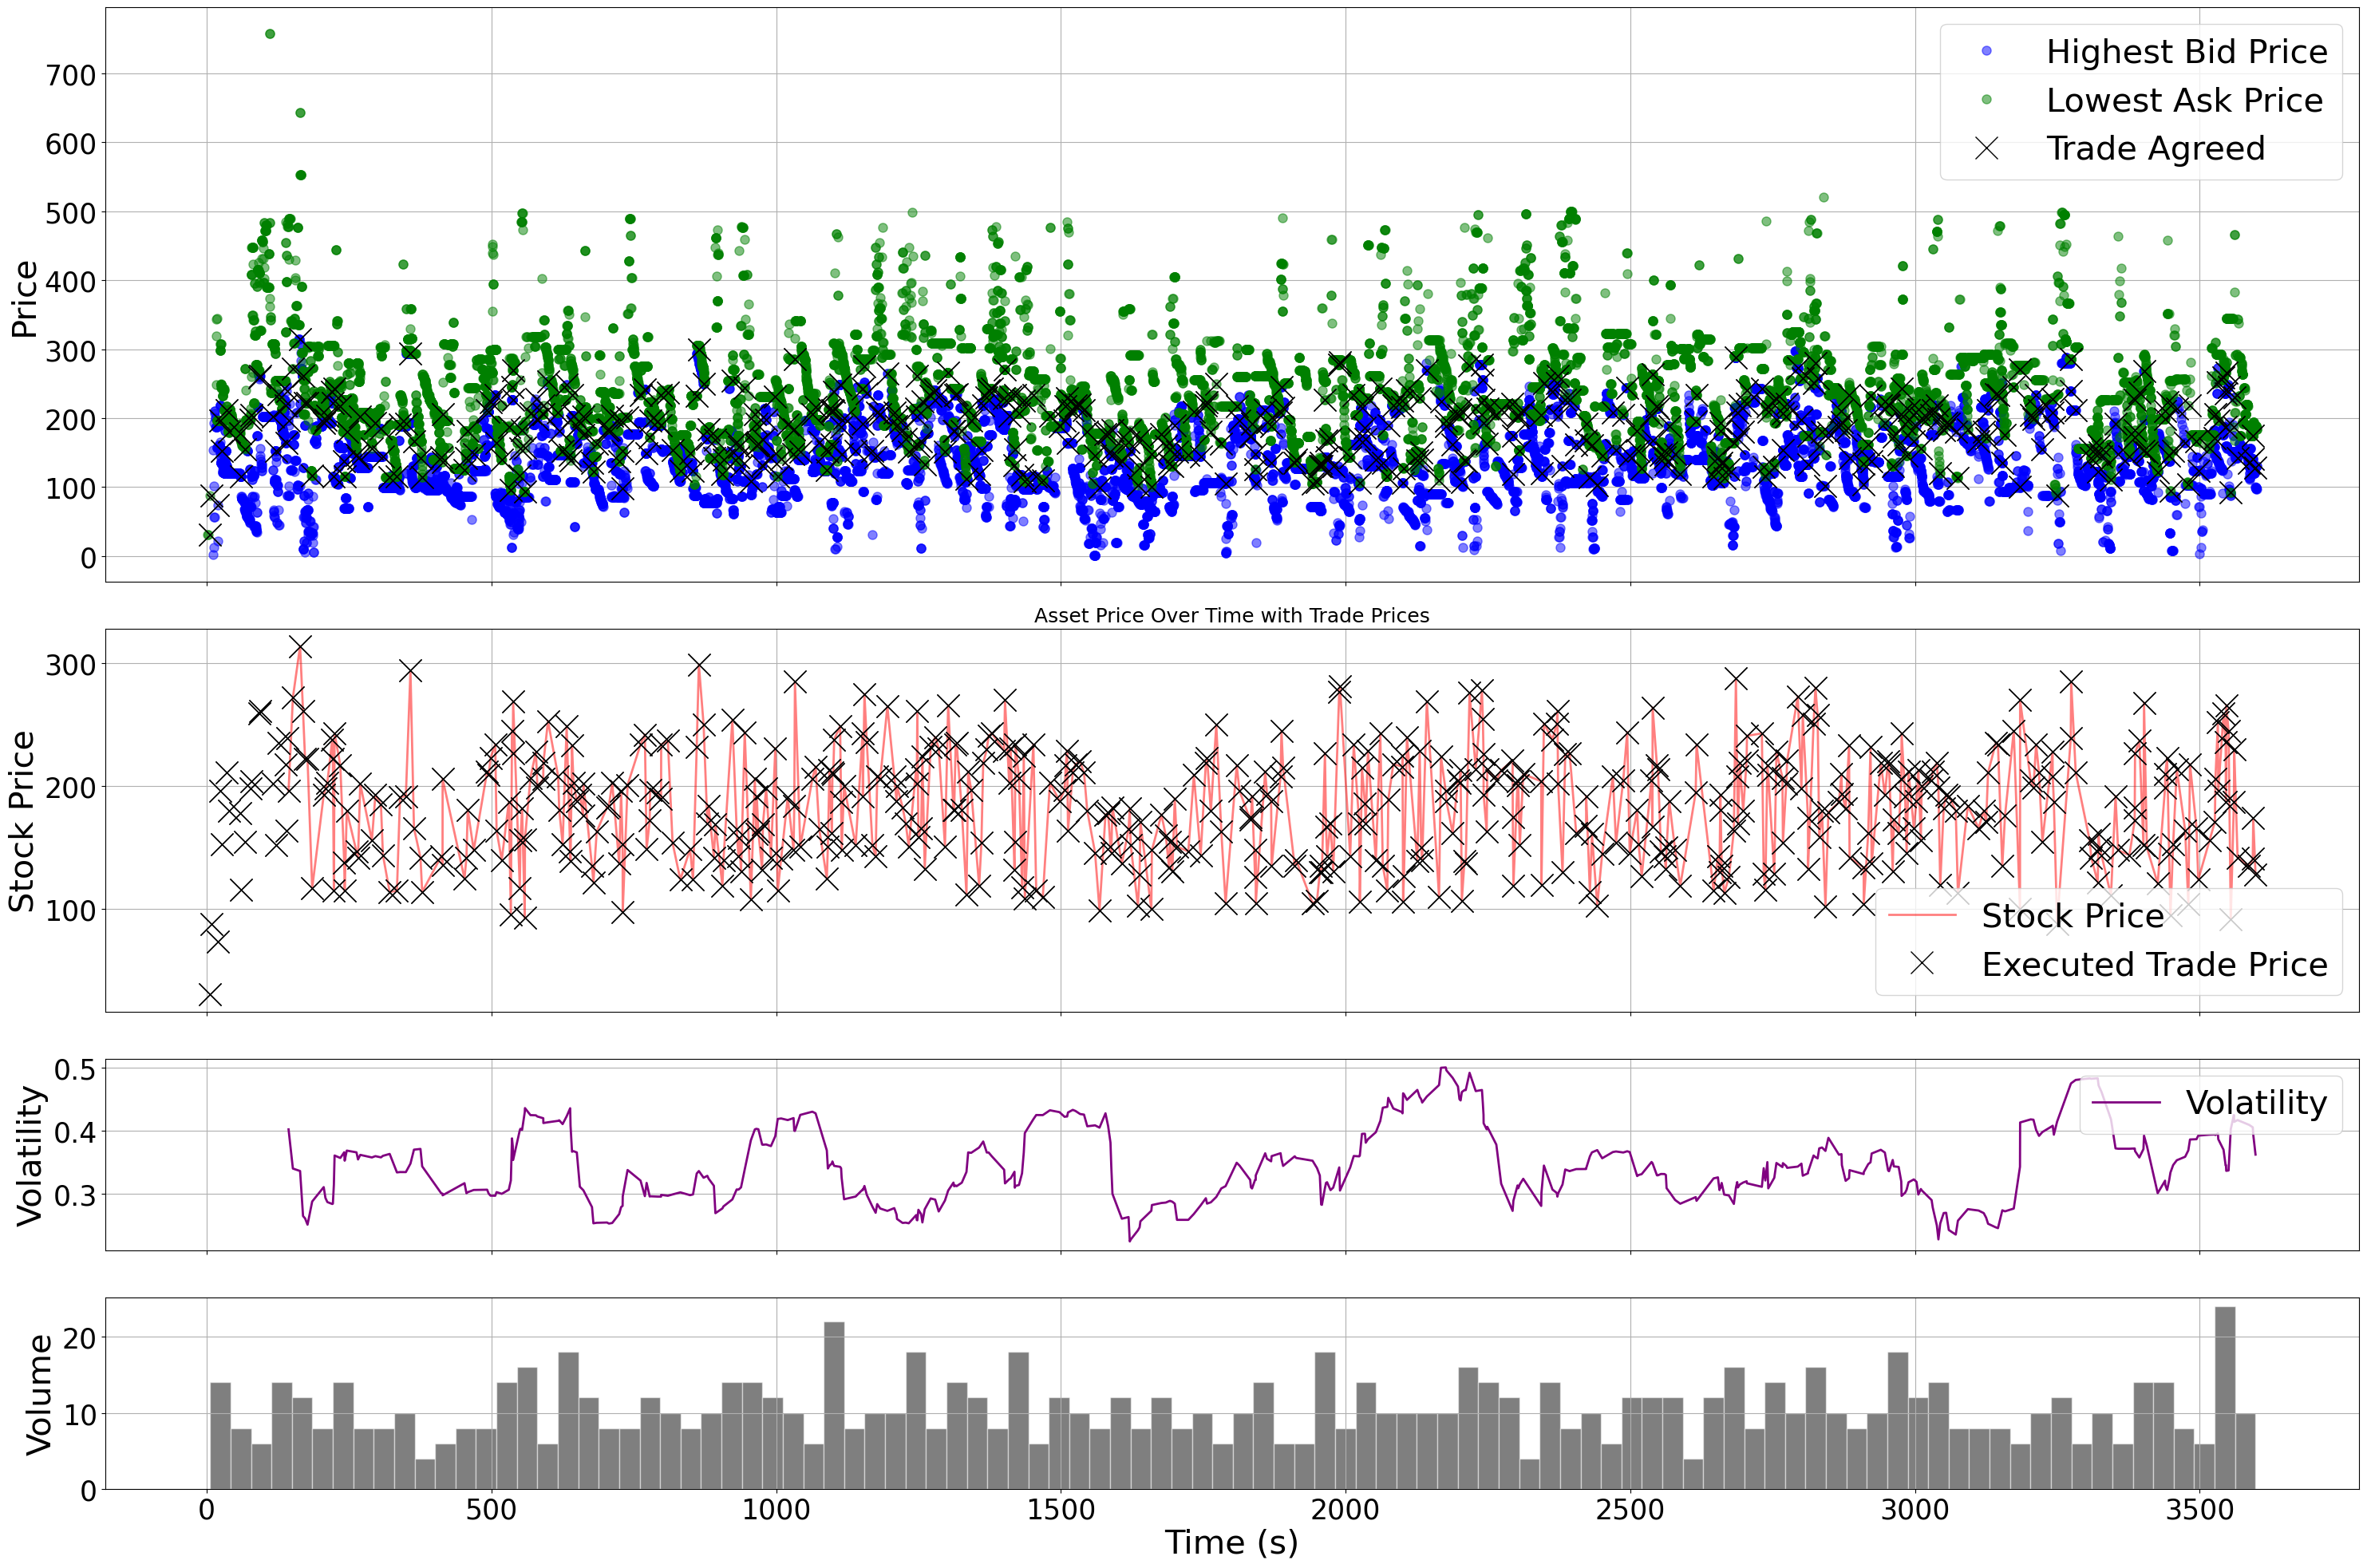

In [572]:
fig = plt.figure(figsize=(30, 20))
gs = gridspec.GridSpec(4, 1, height_ratios=[3, 2, 1,1])  # 3x space for price plot, 1x each for volatility and volume

# Best Bid and Ask prices plot
ax1 = fig.add_subplot(gs[0])
ax1.plot(expanded_df['Time'], [float(prices.split(',')[-1]) if prices else None for prices in expanded_df['Bid Prices']],
         label='Highest Bid Price', color='blue', marker='o', linestyle='', alpha=0.5, markersize = 8) 

ax1.plot(expanded_df['Time'], [float(prices.split(',')[0]) if prices else None for prices in expanded_df['Ask Prices']],
         label='Lowest Ask Price', color='green', marker='o', linestyle='', alpha=0.5, markersize = 8)     
            
ax1.plot(blotters['Timestamp'], blotters['Price'], marker='x', linestyle='none', color='black', label='Trade Agreed', markersize = 20)
ax1.set_ylabel('Price',fontsize = 30)
#ax1.set_title('Highest Bid and Lowest Ask Prices Over Time', fontsize = 34)
ax1.legend(loc = 'upper right', fontsize = 30)
ax1.grid(True)
ax1.tick_params(labelbottom=False)  # Hide x-axis labels and ticks for ax1

# Stock Price plot
ax2 = fig.add_subplot(gs[1], sharex=ax1)  # Share the x-axis with ax1
ax2.plot(tape_df['Time'], tape_df['Price'], color='red', label = 'Stock Price', alpha = 0.5, linewidth = 2)
ax2.plot(blotters['Timestamp'], blotters['Price'], marker='x', linestyle='none', color='black', markersize=20, alpha=1, label = 'Executed Trade Price')
ax2.set_ylabel('Stock Price',fontsize = 30)
ax2.legend(loc = 'lower right',fontsize = 30)
#ax2.set_ylim(100,300)
#ax2.set_title("Asset Price Over Time with Trade Prices")
ax2.tick_params(labelbottom=False)  # Hide x-axis labels and ticks for ax2
ax2.grid(True)

# Volatility plot
ax3 = fig.add_subplot(gs[2], sharex=ax1)  # Share the x-axis with ax1
ax3.plot(tape_df['Time'], tape_df['Volatility'], label='Volatility', color = 'purple', linewidth = 2)
ax3.set_ylabel('Volatility',fontsize = 30)
ax3.legend(loc = 'upper right',fontsize = 30)
ax2.set_title("Asset Price Over Time with Trade Prices")
ax3.tick_params(labelbottom=False)  # Hide x-axis labels and ticks for ax2
ax3.grid(True)

# Volume plot
ax4 = fig.add_subplot(gs[3], sharex=ax1)  # Share the x-axis with ax1
ax4.hist(blotters['Timestamp'], bins=100, edgecolor='white', alpha=0.5, color='black')
ax4.set_xlabel('Time (s)',fontsize = 30)  # Only set x-axis label for the bottom plot
ax4.set_ylabel('Volume',fontsize = 30)
ax4.grid(True)


# Adjust layout to avoid overlap
ax1.tick_params(axis='y', labelsize=25)
ax2.tick_params(axis='y', labelsize=25)
ax3.tick_params(axis='y', labelsize=25)
ax4.tick_params(axis='y', labelsize=25)
ax4.tick_params(axis='x', labelsize=25)
plt.tight_layout()
plt.show()

------

### Looking to see how traders prices are distributed

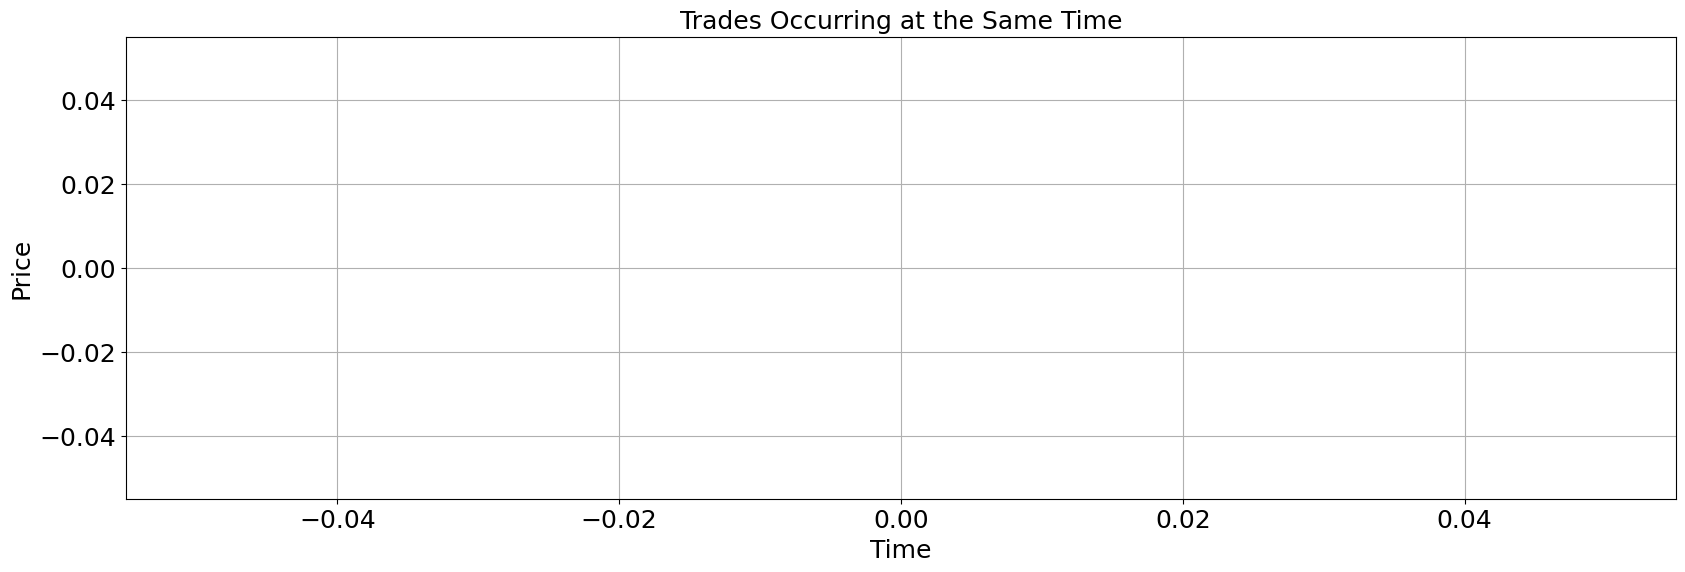

In [573]:
# Find duplicate times in the 'Time' column
duplicate_times = tape_df[tape_df.duplicated(subset='Time', keep=False)]
duplicate_times.shape
# Plot the duplicate trades
plt.figure(figsize=(20, 6))
plt.scatter(duplicate_times['Time'], duplicate_times['Price'], color='red', marker='x', label='Duplicate Trades')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Trades Occurring at the Same Time')
#plt.legend()
plt.grid(True)
plt.show()

# Histogram of bids and asks 

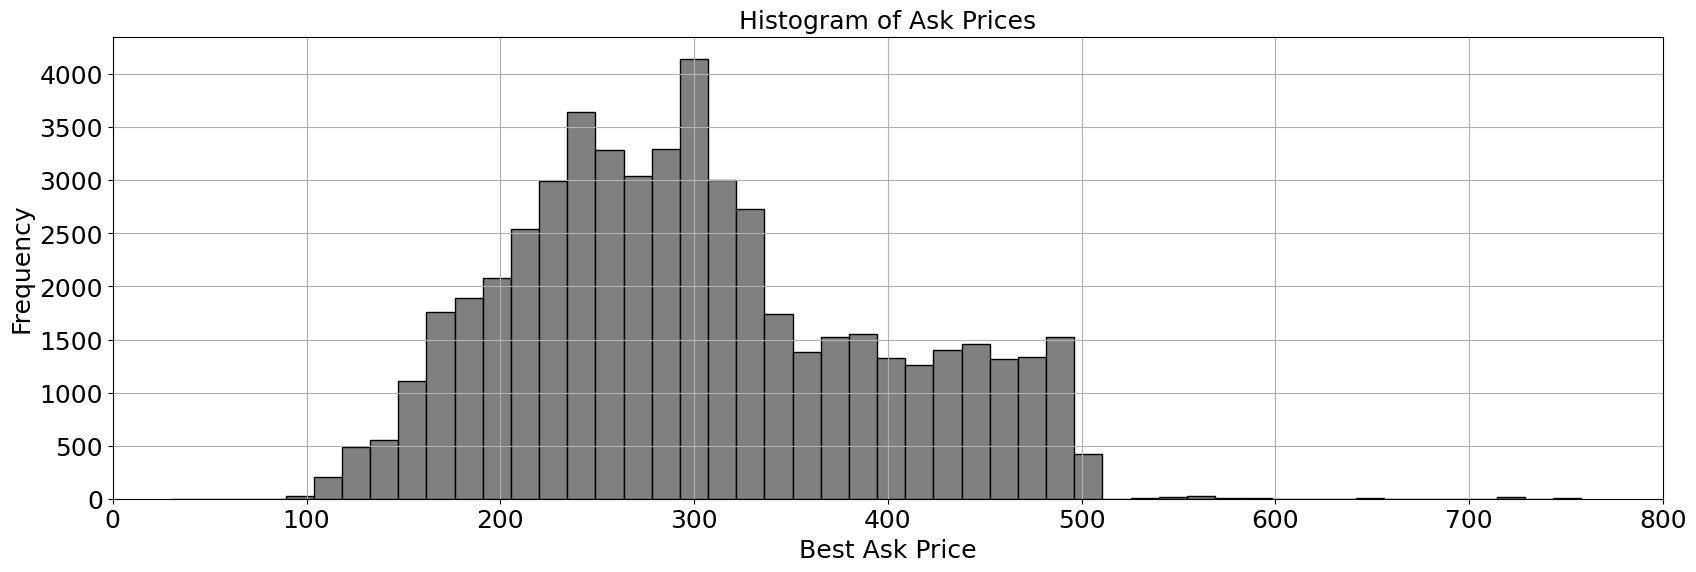

In [574]:
expanded_df['Ask Prices'] = expanded_df['Ask Prices'].apply(
    lambda x: [float(price) for price in x.split(',')] if isinstance(x, str) and x else [])
expanded_df['Best Ask Price'] = expanded_df['Ask Prices'].apply(lambda prices: min(prices) if prices else None)
#best_ask_prices = expanded_df['Best Ask Price'].dropna()
best_ask_prices = [price for sublist in expanded_df['Ask Prices'] for price in sublist if sublist]

# Step 4: Plot the histogram of the best ask prices
plt.figure(figsize=(20, 6))
plt.hist(best_ask_prices, bins=50, color='grey', edgecolor='black')
plt.xlabel('Best Ask Price')
plt.ylabel('Frequency')
plt.title('Histogram of Ask Prices')
plt.xlim(0, 800)
plt.grid(True)
plt.show()


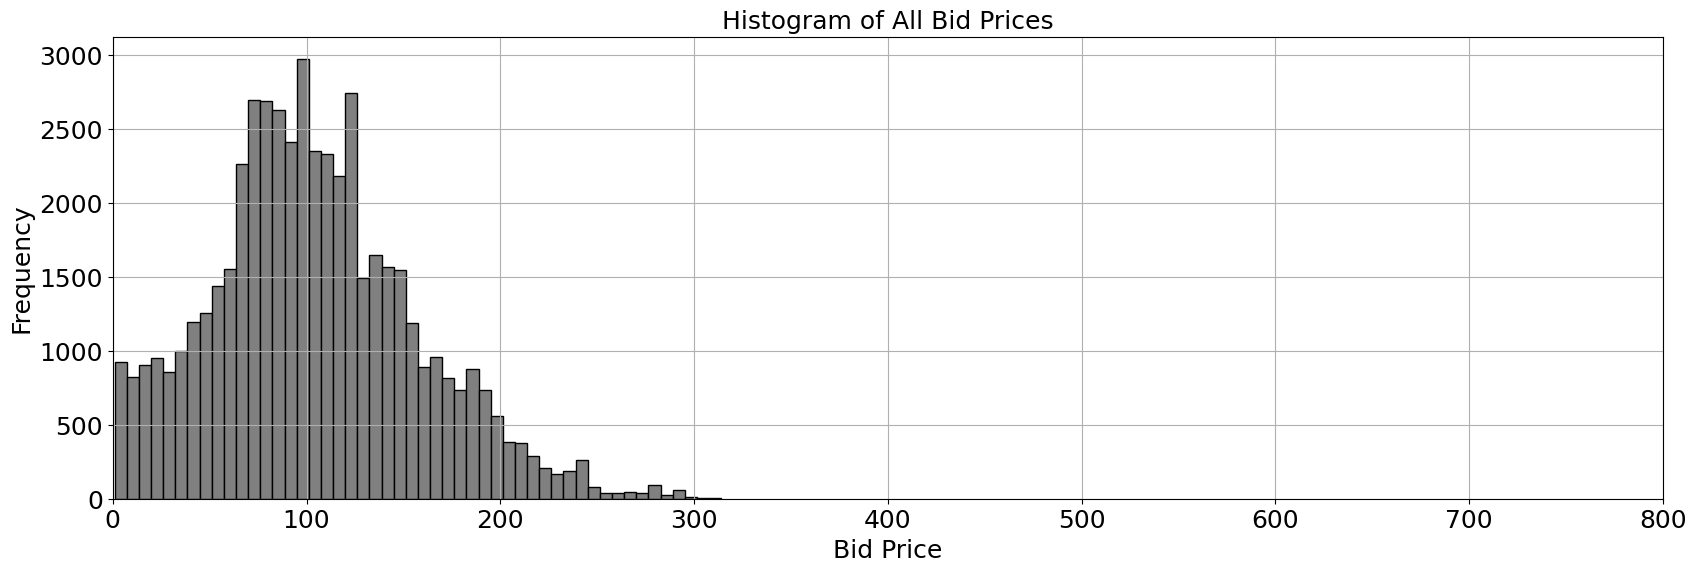

In [575]:
# Ensure 'Ask Prices' is a list of floats
expanded_df['Bid Prices'] = expanded_df['Bid Prices'].apply(
    lambda x: [float(price) for price in x.split(',')] if isinstance(x, str) and x else []
)

# Flatten all ask prices into a single list
all_ask_prices = [price for sublist in expanded_df['Bid Prices'] for price in sublist if sublist]

# Plot the histogram of all ask prices
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
plt.hist(all_ask_prices, bins=50, color='grey', edgecolor='black')
plt.xlabel('Bid Price')
plt.ylabel('Frequency')
plt.title('Histogram of All Bid Prices')
plt.xlim(0, 800)
plt.grid(True)
plt.show()


----



### Plot average balances 

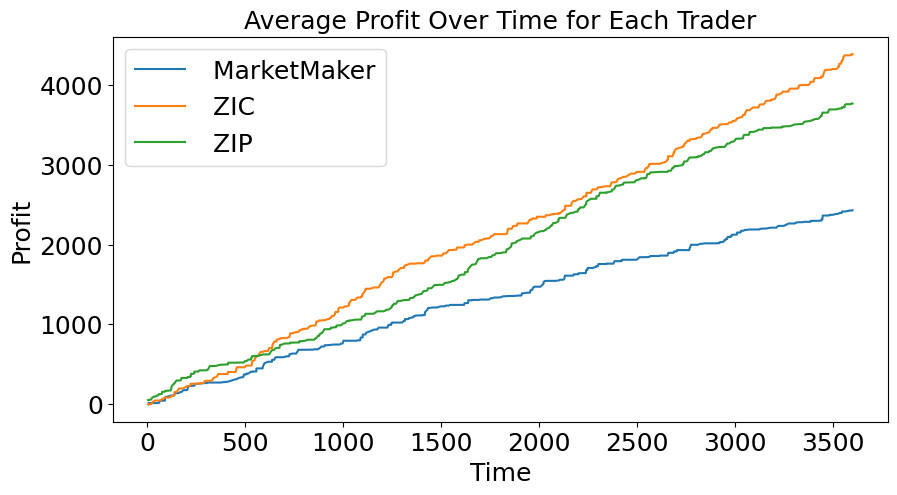

In [576]:
# Load the CSV file
df = pd.read_csv(balances, header=None)

# Extract time column
time = df[1]

# Dictionary to store trader type time series
trader_time_series = {}

# Iterate over trader type data in the CSV
for col in range(7, df.shape[1], 4):  # Average balance column starts at 7
    trader_name_col = col - 3  # Column where trader type name is stored
    avg_balance_col = col  # Column with average balance values

    trader_name = df.iloc[0, trader_name_col]  # Get trader type name
    avg_balances = df[avg_balance_col]  # Get average balance series

    trader_time_series[trader_name] = avg_balances

# Plot average balances over time
plt.figure(figsize=(10, 5))
for trader_name, avg_balances in trader_time_series.items():
    plt.plot(time, avg_balances, label=trader_name)

plt.xlabel('Time')
plt.ylabel('Profit')
plt.title('Average Profit Over Time for Each Trader')
plt.legend()
plt.grid(False)
plt.show()


### Profit per second plot

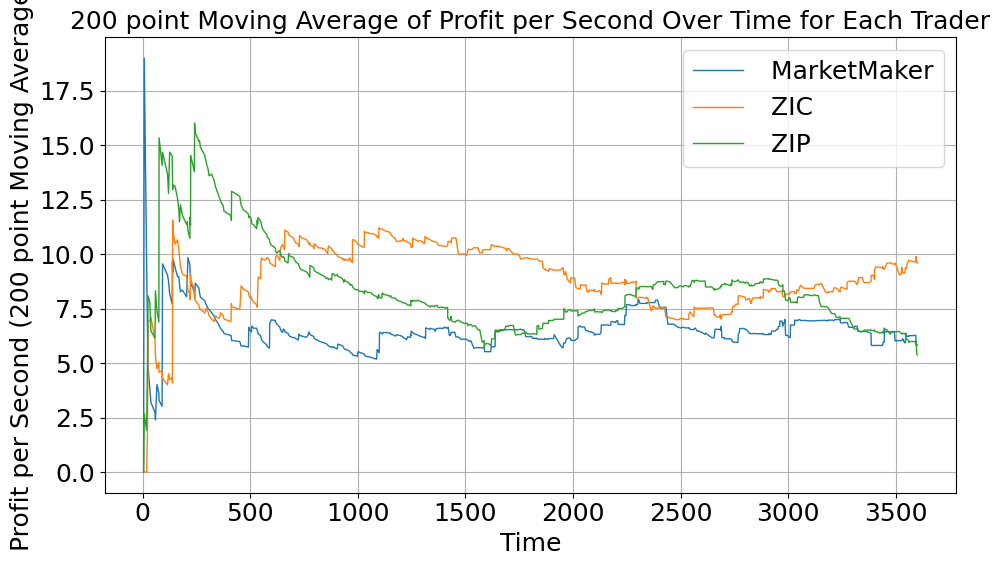

In [577]:
time = balances_df[1]
time_diff = time.diff().fillna(1)  # Replace NaN with 1 to avoid division issues
profit_per_second = {}

# Start reading trader data from column 5 (name) and column 6 (balance), incrementing by 4 for each trader
for col in range(5, balances_df.shape[1], 4):
    trader_name_col = col - 1
    balance_col = col
    
    # Get trader name from the first row for this column
    trader_name = balances_df.iloc[0, trader_name_col]
    
    # Get the balance column for this trader over time
    balances = balances_df[balance_col]
    # Calculate the profit difference and divide by the time difference
    profit_diff = balances.diff()
    profit_rate = profit_diff / time_diff
    # Calculate a 200-point moving average for the profit per second
    profit_rate_smoothed = profit_rate.rolling(window=200, min_periods=1).mean()
    # Fill NaN values at the start of the data with 0 or by forward filling
    profit_rate_smoothed = profit_rate_smoothed.fillna(0)
    # Store in dictionary
    profit_per_second[trader_name] = profit_rate_smoothed

# Plotting the profit per second for each trader as a line graph
plt.figure(figsize=(10, 6))
for trader_name, profit_rate in profit_per_second.items():
    plt.plot(time, profit_rate, label=trader_name, linewidth=1)  # Setting linewidth to make the line more prominent

# Labeling the plot
plt.xlabel('Time')
plt.ylabel('Profit per Second (200 point Moving Average)')
#plt.ylim(0,80)
plt.title('200 point Moving Average of Profit per Second Over Time for Each Trader')
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.ylim(0,40)
plt.show()
